# Data Inspection 
### Imports

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

df = pd.read_csv('train.csv')
df = df.rename({
    '1stFlrSF':'FirstFlrSF', 
    '2ndFlrSF':'SecFlrSF',
    '3SsnPorch':'ThreeSsnPorch'
}, axis=1)

### Helper Functions

In [148]:
def gaussian_fit(df, col, ax=None, bins=30):
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(df[col], bins=bins, density=True)
    x = np.linspace(*plt.xlim(), 100)
    ax.plot(x, norm.pdf(x, *norm.fit(df[col].dropna())))
    ax.set_xlabel(col)
    return

#### Inspection

<AxesSubplot: xlabel='Feature', ylabel='Log(1+nunique)'>

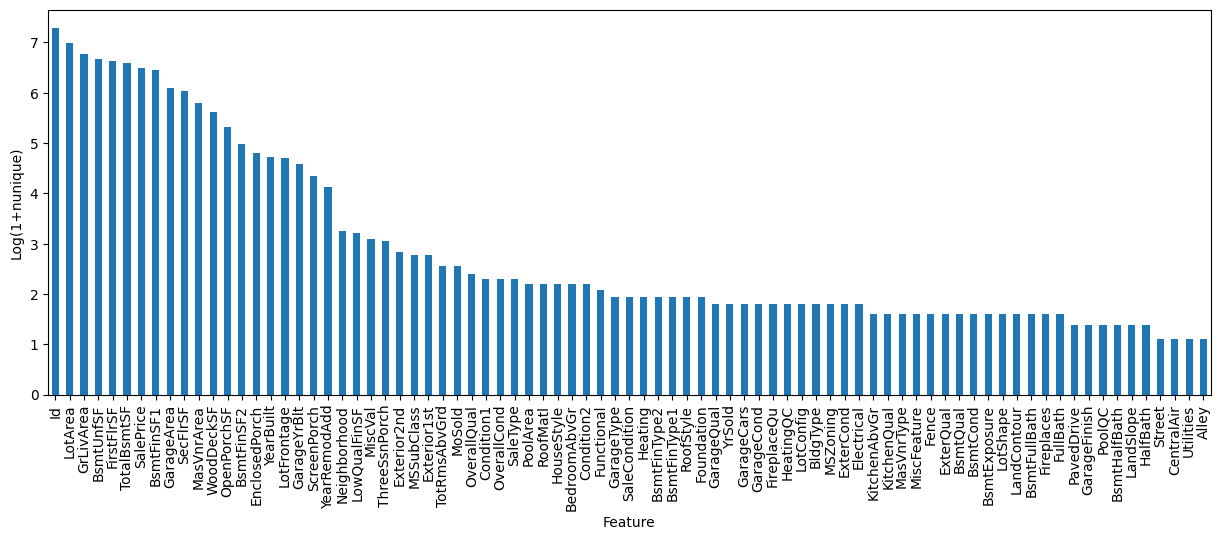

In [149]:
fig, ax = plt.subplots(figsize=(15,5))
(
    np.log1p(df.nunique()).sort_values(ascending=False)
    .plot.bar(xlabel='Feature', ylabel='Log(1+nunique)', ax=ax)
)


Lots of categories. This gives me an idea of which are numerical vs categorical, but it is not a perfect split as Neighborhood is categorical but has more unique values than PoolArea.

<AxesSubplot: xlabel='Feature', ylabel='Null Percentage'>

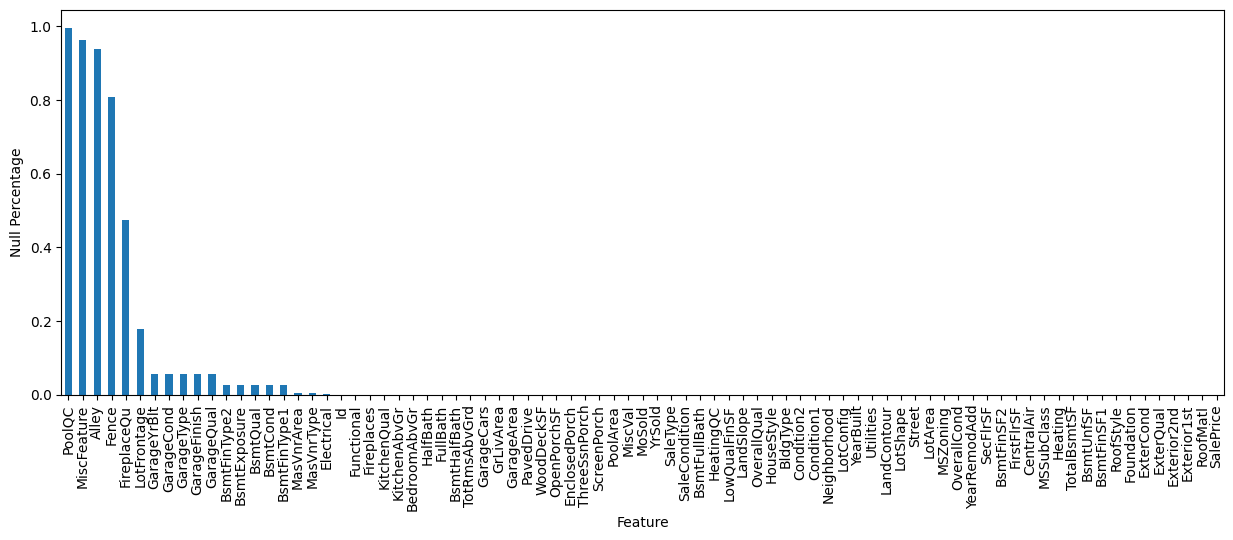

In [150]:
# null percentages
fig, ax = plt.subplots(figsize=(15,5))
(  
    df.isna().sum().sort_values(ascending=False).divide(len(df))
    .plot.bar(xlabel='Feature', ylabel='Null Percentage')
)

Let's look at the features with the most null values. Some of these seem like they could still be important. For example, if a house doesn't have a fireplace then the quality would be nan. But maybe that information is still important...

This wasn't very helpful. Now we look at the factors that have largest correlations. It is better to focus on features that are helpful instead of trying to remove bad features (that would be a lot to prune!).

<AxesSubplot: ylabel='FireplaceQu'>

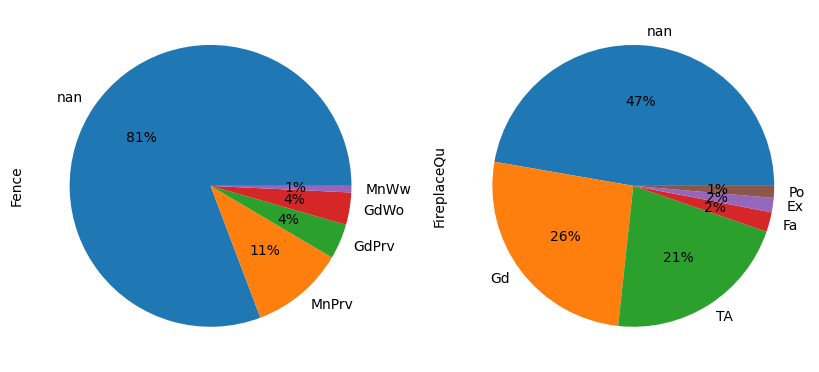

In [151]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
df.Fence.value_counts(dropna=False).plot.pie(autopct='%.0f%%', ax=ax[0])
df.FireplaceQu.value_counts(dropna=False).plot.pie(autopct='%.0f%%', ax=ax[1])

### Encodings
Many of the features are graded on a category scale that easily maps to a numeric ordering. We do this now so it will be captured in the numeric-only plots.

In [152]:
Excellent_to_Poor_map = {'Ex':2, 'Gd':1, 'TA':0, 'Fa':-1, 'Po':-2, 'NA':np.nan}
BsmtFinType_map = {'NA':np.nan, 'Unf':0, 'LwQ':1, 'Rec':2, 'BLQ':3, 'ALQ':4, 'GLQ':5}

df['HeatingQCnum'] = df.HeatingQC.map(Excellent_to_Poor_map)
df['ExterQualnum']  = df.ExterQual.map(Excellent_to_Poor_map)
df['ExterCondnum']  = df.ExterCond.map(Excellent_to_Poor_map)
df['BsmtQualnum']  = df.BsmtQual.map(Excellent_to_Poor_map)
df['BsmtCondnum']  = df.BsmtCond.map(Excellent_to_Poor_map)
df['HeatingQCnum']  = df.HeatingQC.map(Excellent_to_Poor_map)
df['KitchenQualnum']  = df.KitchenQual.map(Excellent_to_Poor_map)
df['FireplaceQunum']  = df.FireplaceQu.map(Excellent_to_Poor_map)
df['GarageQualnum']  = df.GarageQual.map(Excellent_to_Poor_map)
df['GarageCondnum']  = df.GarageCond.map(Excellent_to_Poor_map)
df['PoolQCnum']  = df.PoolQC.map(Excellent_to_Poor_map)
df['BsmtFinType1num']  = df.BsmtFinType1.map(BsmtFinType_map)
df['BsmtFinType2num']  = df.BsmtFinType2.map(BsmtFinType_map)
df['LotShapenum']  = df.LotShape.map({'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3})
df['LandContournum']  = df.LandContour.map({'Lvl':0, 'Bnk':1, 'HLS':2, 'Low':2})
df['LandSlopenum']  = df.LandSlope.map({'Gtl':0, 'Mod':1, 'Sev':2})
df['GarageFinishnum']  = df.GarageFinish.map({'NA':np.nan, 'Unf':0, 'RFn':1, 'Fin':2})
df['CentralAirnum']  = df.CentralAir.map({'Y':1, 'N':0})
df['BsmtExposurenum']  = df.BsmtExposure.map({'NA':np.nan, 'No':0, 'Mn':1, 'Av':2, 'Gd':3})
df['CentralAirnum']  = df.CentralAir.map({'Y':1, 'N':0})
df['Functionalnum']  = df.Functional.map({'Typ':0, 'Min1':1, 'Min2':2, 'Mod':3, 'Maj1':4, 'Maj2':5, 'Sev':6, 'Sal':7})

### Correlations
We are testing against the log of the SalePrice, so create new column. Try to create new features that combine information of multiple features into single that has better correlation. Where there is correlation, try to make it linear.

<AxesSubplot: xlabel='Feature', ylabel='Correlation'>

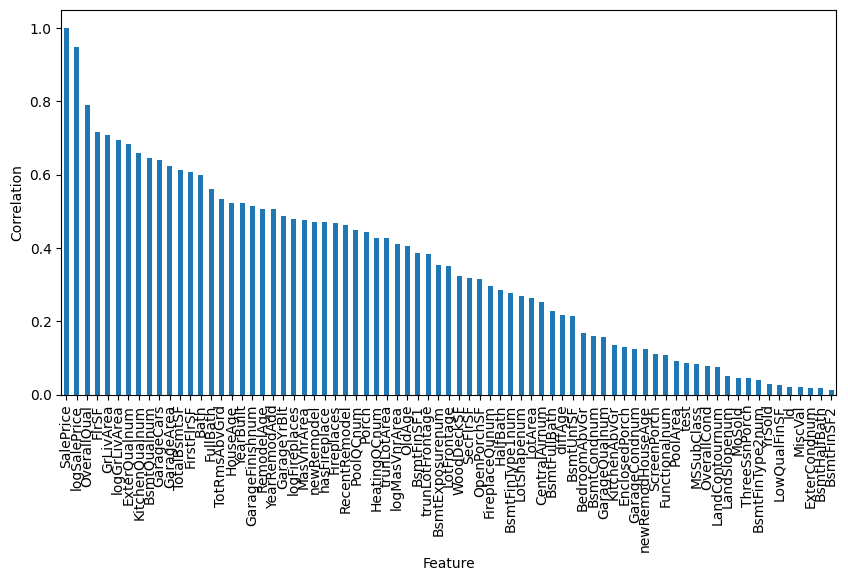

In [279]:
# Correlations, remember these are only the numeric ones...
df['logSalePrice'] = np.log1p(df.SalePrice)
df['binlogSalePrice'] = pd.qcut(df.logSalePrice, q=10)
df['logGrLivArea'] = np.log1p(df.GrLivArea)
df['Bath'] = df.FullBath + 0.5*df.HalfBath
df['trunLotArea'] = np.where(df.LotArea>20000, 20000, df.LotArea)
df['Porch'] = df.WoodDeckSF + df.ScreenPorch+df.OpenPorchSF+df.ThreeSsnPorch
fig, ax = plt.subplots(figsize=(10,5))
( 
    df.corrwith(df.SalePrice, numeric_only=True).abs().sort_values(ascending=False)
    .plot.bar(xlabel='Feature', ylabel='Correlation')
)

<AxesSubplot: xlabel='OverallQual', ylabel='logSalePrice'>

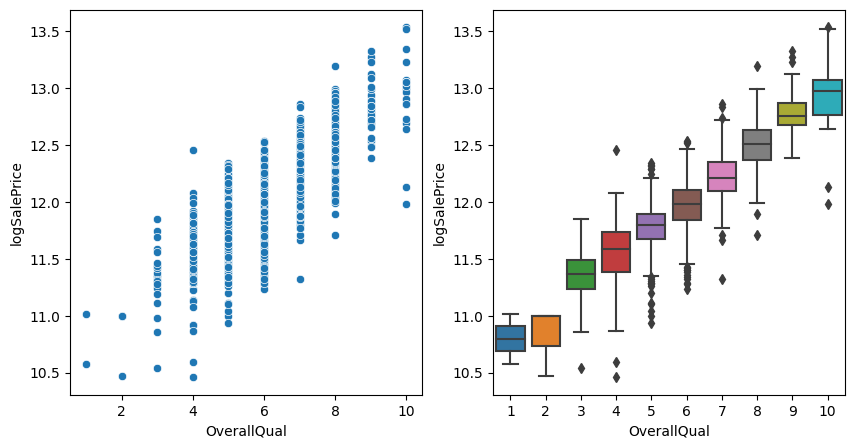

In [154]:
# Very linear relationship with OverallQual!
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=df, x='OverallQual', y='logSalePrice', ax=ax[0])
sns.boxplot(data=df, x='OverallQual', y='logSalePrice', ax=ax[1])

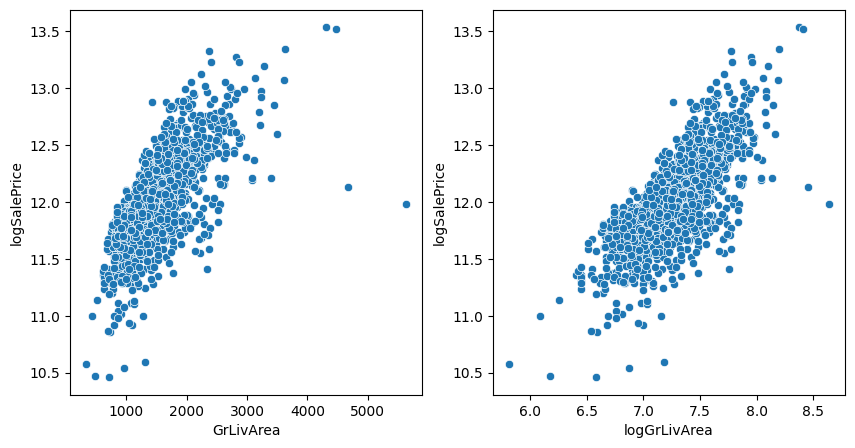

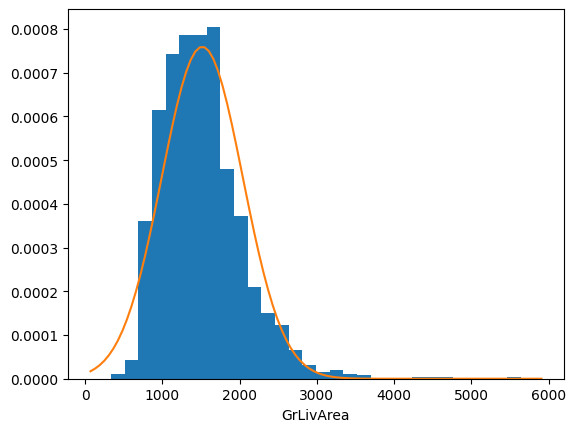

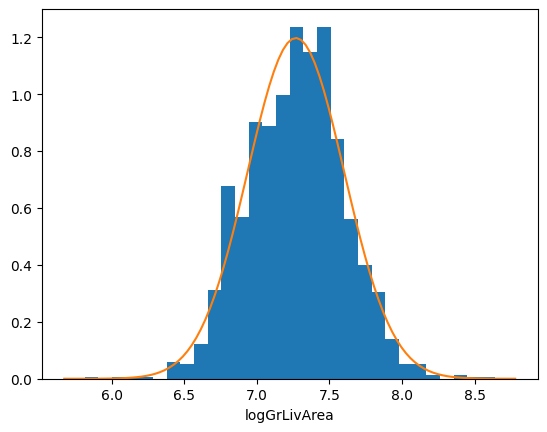

In [155]:
# Rather use logGrLivArea because it has gaussian shape?
# Test one vs the other?
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
df['logGrLivArea'] = np.log1p(df.GrLivArea)
sns.scatterplot(data=df, x='GrLivArea', y='logSalePrice', ax=ax[0])
sns.scatterplot(data=df, x='logGrLivArea', y='logSalePrice', ax=ax[1])

gaussian_fit(df=df, col='GrLivArea')
gaussian_fit(df=df, col='logGrLivArea')

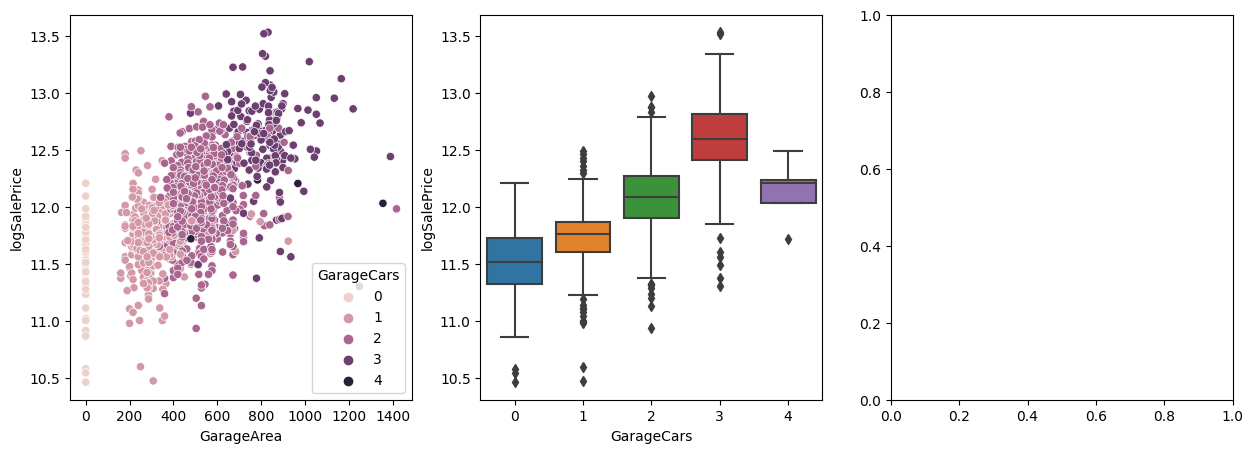

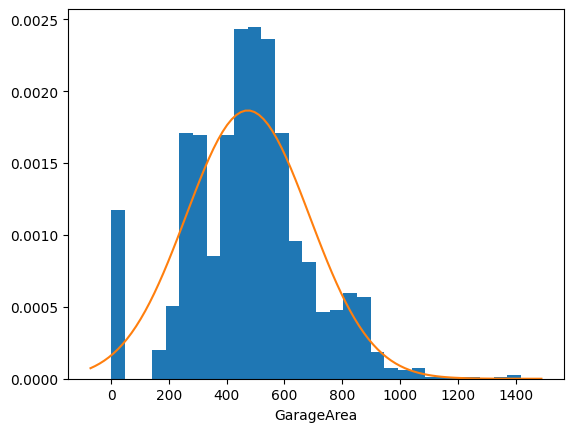

In [215]:
# There contain the same information.
# I don't see a good reason to use both. 
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(data=df, x='GarageArea', y='logSalePrice', ax=ax[0], hue='GarageCars')
sns.boxplot(data=df, x='GarageCars', y='logSalePrice', ax=ax[1])
gaussian_fit(df=df, col='GarageArea')

<AxesSubplot: xlabel='GarageFinishnum', ylabel='logSalePrice'>

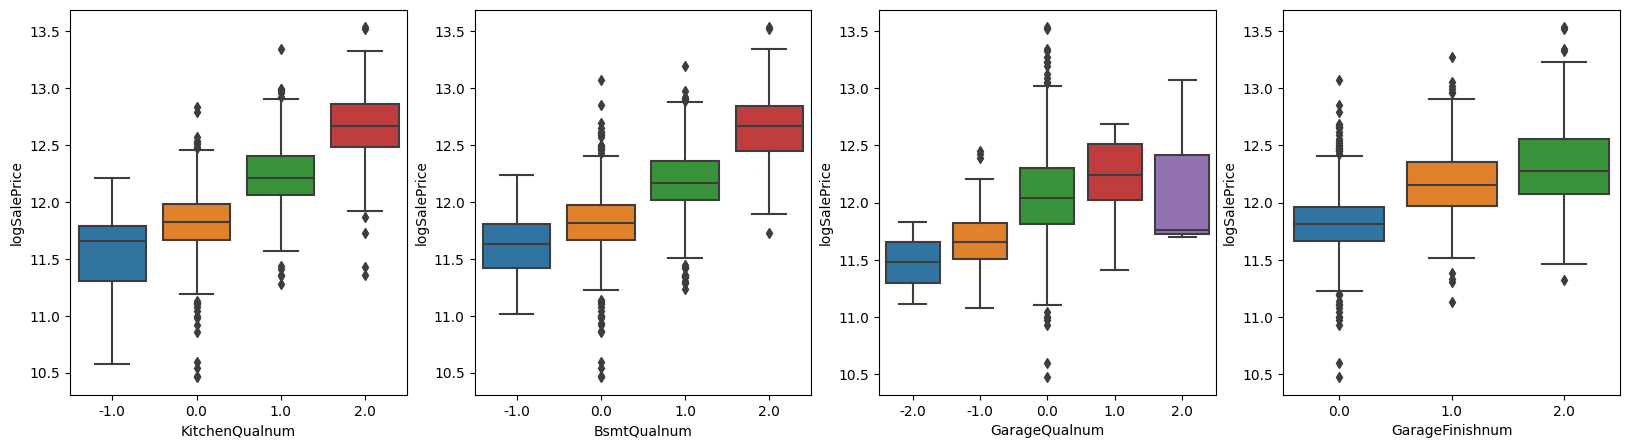

In [217]:
# Very linear relationships with KitchenQual, BsmtQual. GarageQual has that dip for the higher end
# that we've seen before with garage size.
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
sns.boxplot(data=df, x='KitchenQualnum', y='logSalePrice', ax=ax[0])
sns.boxplot(data=df, x='BsmtQualnum', y='logSalePrice', ax=ax[1])
sns.boxplot(data=df, x='GarageQualnum', y='logSalePrice', ax=ax[2])
sns.boxplot(data=df, x='GarageFinishnum', y='logSalePrice', ax=ax[3])

<AxesSubplot: xlabel='Bath', ylabel='logSalePrice'>

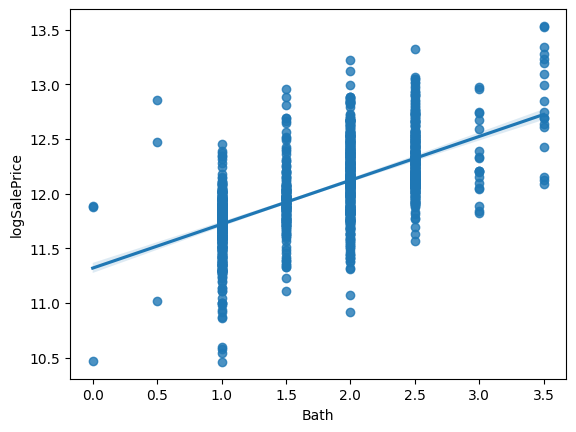

In [158]:
sns.regplot(data=df, x='Bath', y='logSalePrice')

<AxesSubplot: xlabel='test', ylabel='logSalePrice'>

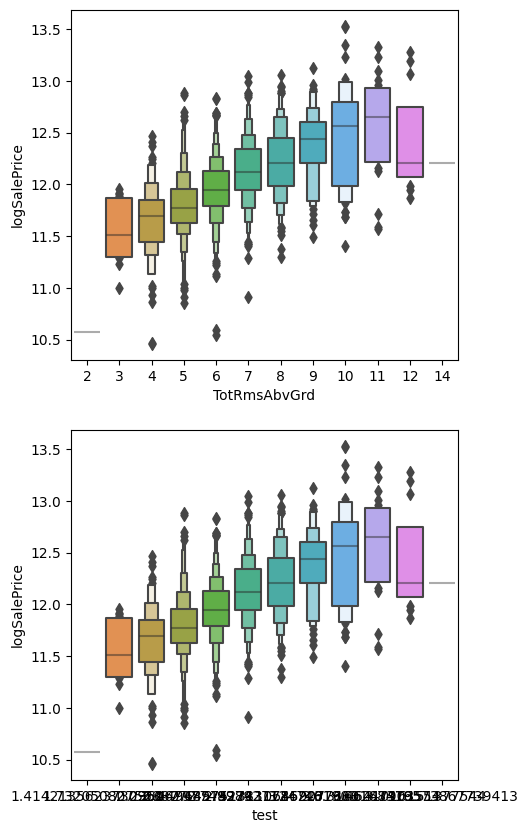

In [178]:
# Rooms Above Ground
sns.boxenplot(data = df, x='TotRmsAbvGrd', y='logSalePrice')


<AxesSubplot: xlabel='RemodelAge', ylabel='logSalePrice'>

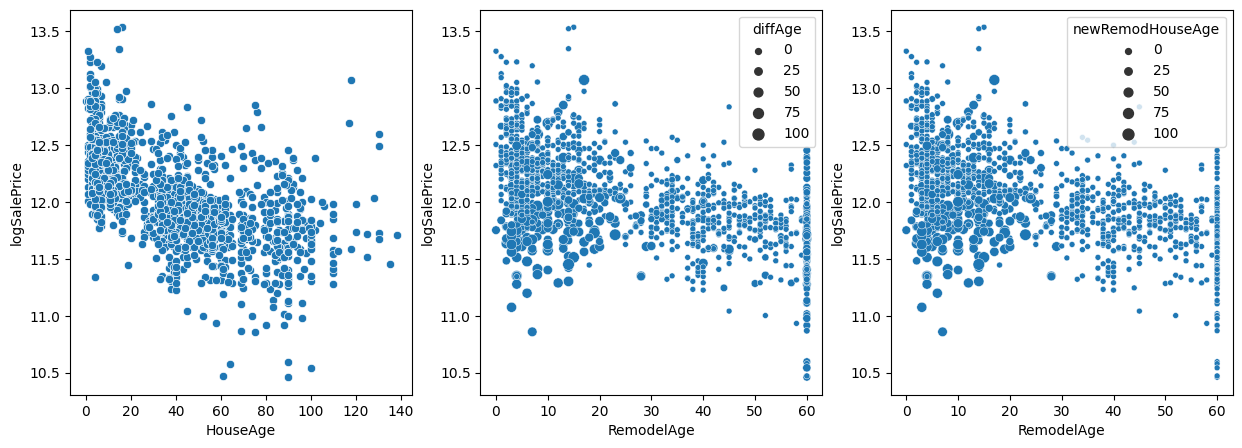

In [214]:
# Year built and remodel
# The HouseAge scatter plot is linear until 60, and is then flat. The truncation of RemodelAge (nothing older than 1950?) is 
# actually helpful for making the relationship linear. The difference between House and Remodel age is important for newer remodels. 
# So we create a new feature that will adjust prices for new remodels only.
df['HouseAge'] = 2010-df.YearBuilt
df['RemodelAge'] = 2010-df.YearRemodAdd
df['newRemodel'] = np.where(df.RemodelAge<30, 1, 0)
df['diffAge'] = df.HouseAge-df.RemodelAge
df['newRemodHouseAge'] = (df.HouseAge-df.RemodelAge)*df.newRemodel



fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.scatterplot(data=df, x='HouseAge', y='logSalePrice', ax=ax[0])
sns.scatterplot(data=df, x='RemodelAge', y='logSalePrice', ax=ax[1], size='diffAge')
sns.scatterplot(data=df, x='RemodelAge', y='logSalePrice', ax=ax[2], size='newRemodHouseAge')

<AxesSubplot: xlabel='logMasVnrArea', ylabel='logSalePrice'>

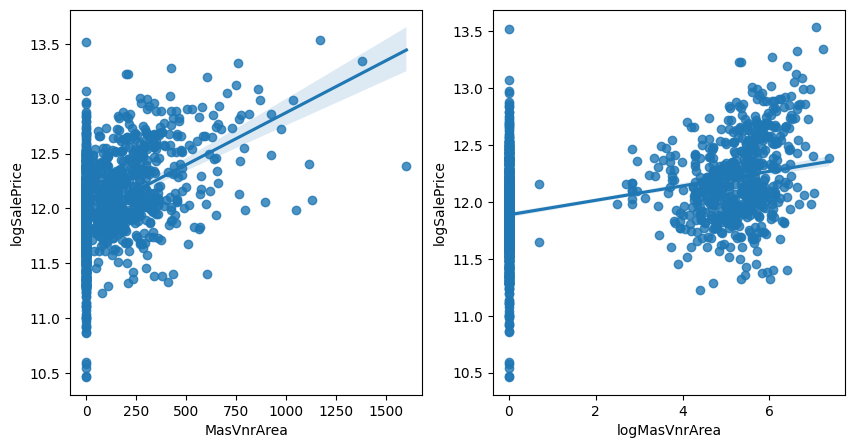

In [225]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
df['logMasVnrArea'] = np.log1p(df.MasVnrArea)
sns.regplot(data=df, x='MasVnrArea', y='logSalePrice', ax=ax[0])
sns.regplot(data=df, x='logMasVnrArea', y='logSalePrice', ax=ax[1])



<AxesSubplot: xlabel='hasFireplace', ylabel='logSalePrice'>

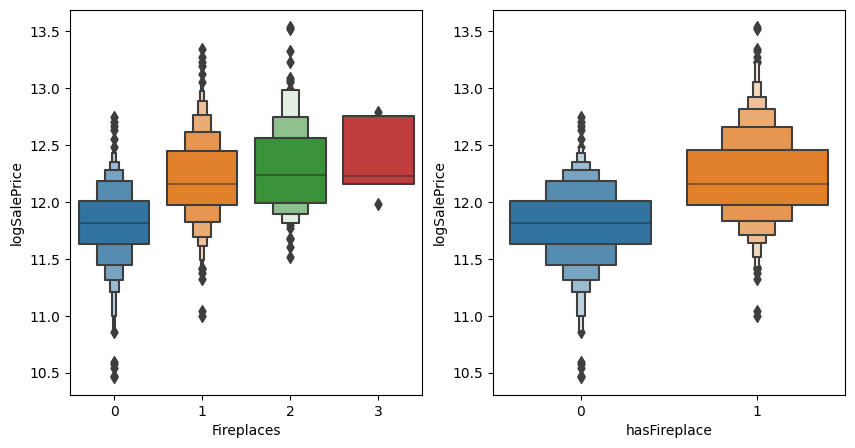

In [229]:
# Clear benefit to having fireplace, but not much difference between 1-3. Just have feature for if a fireplace exists.
df['hasFireplace'] = np.where(df.Fireplaces>0, 1, 0)
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxenplot(data=df, x='Fireplaces', y='logSalePrice', ax=ax[0])
sns.boxenplot(data=df, x='hasFireplace', y='logSalePrice', ax=ax[1])

<AxesSubplot: xlabel='HeatingQCnum', ylabel='logSalePrice'>

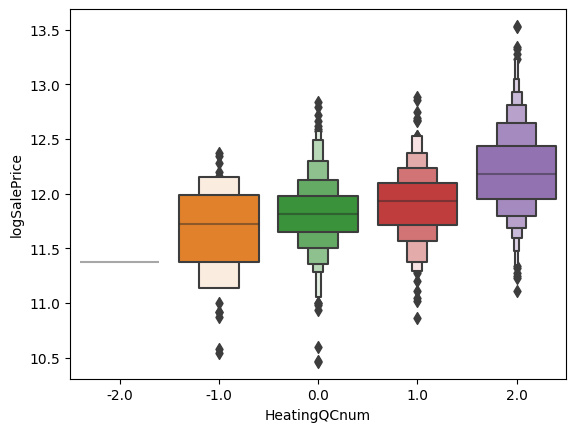

In [232]:

sns.boxenplot(data=df, x='HeatingQCnum', y='logSalePrice')

<AxesSubplot: xlabel='BsmtExposurenum', ylabel='logSalePrice'>

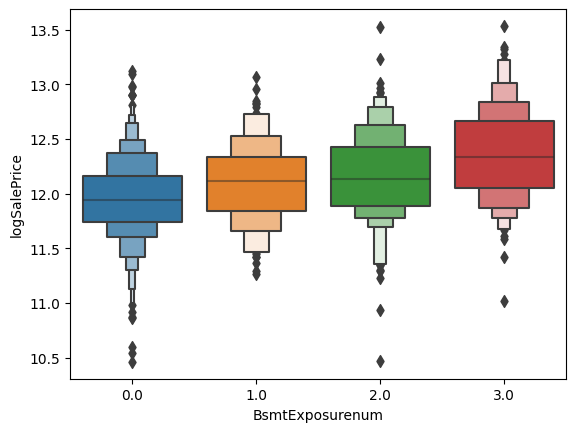

In [255]:
sns.boxenplot(data=df, x='BsmtExposurenum', y='logSalePrice')

<AxesSubplot: xlabel='trunLotFrontage', ylabel='logSalePrice'>

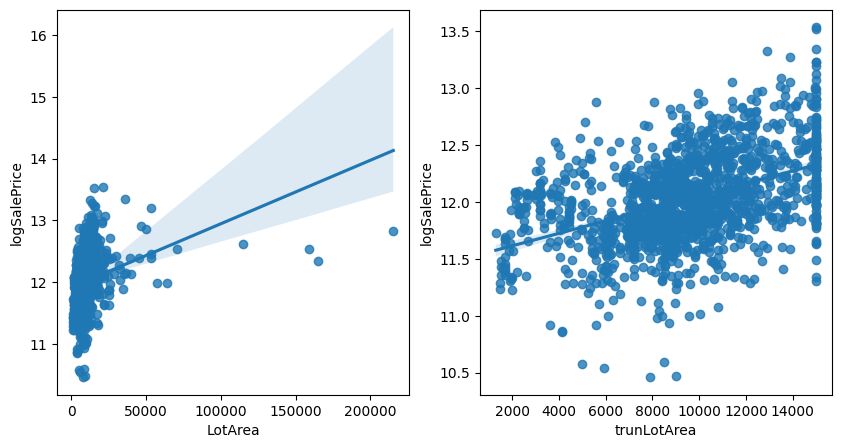

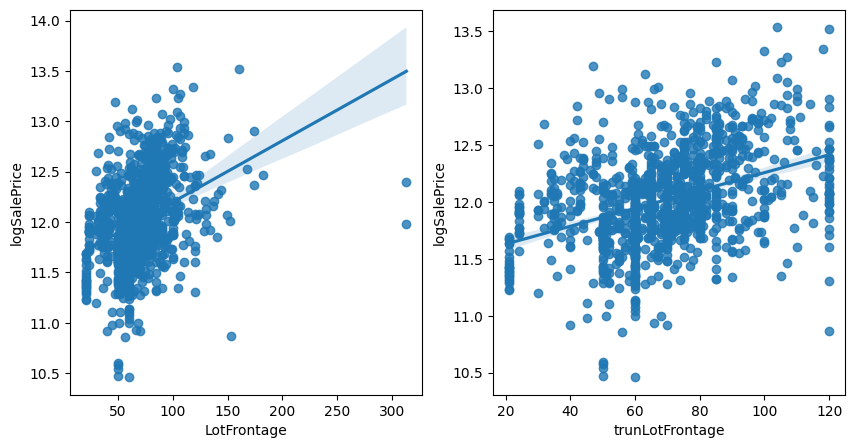

In [253]:
# Truncating Lot Area gives much better fit.
max_LotArea = 15000
df['trunLotArea'] = np.where(df.LotArea>max_LotArea, max_LotArea, df.LotArea)
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.regplot(data=df, x='LotArea', y='logSalePrice', ax=ax[0])
sns.regplot(data=df, x='trunLotArea', y='logSalePrice', ax=ax[1])

max_LotFrontage = 120
df['trunLotFrontage'] = np.where(df.LotFrontage>max_LotFrontage, max_LotFrontage, df.LotFrontage)
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.regplot(data=df, x='LotFrontage', y='logSalePrice', ax=ax[0])
sns.regplot(data=df, x='trunLotFrontage', y='logSalePrice', ax=ax[1])


<AxesSubplot: xlabel='WoodDeckSF', ylabel='logSalePrice'>

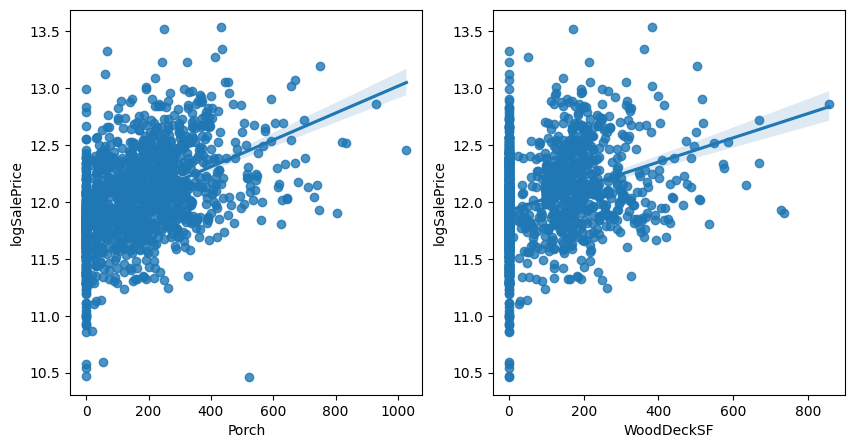

In [285]:
# Porches
# WoodDeck is linear
# OpenPorchSF is yes/no
# ThreeSsnPorch is yes/no
# ScreenPorch is linear
# Enclosed Porch is slight negative effect
df['Porch'] = df.WoodDeckSF + df.ScreenPorch + df.OpenPorchSF + df.ThreeSsnPorch

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.regplot(data=df, x='Porch', y='logSalePrice', ax=ax[0])
sns.regplot(data=df, x='WoodDeckSF', y='logSalePrice', ax=ax[1])

<AxesSubplot: xlabel='Bedrooms1_4', ylabel='logSalePrice'>

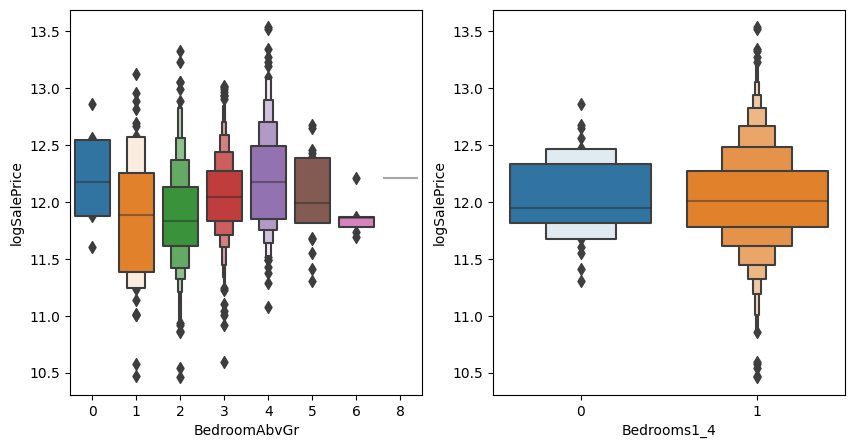

In [297]:
# Bedrooms 2-4 have the most numbers and a strong linear region
# How to only give values based on that?
df['Bedrooms2_4'] = np.where(df.BedroomAbvGr.between(2,4), 1, 0)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxenplot(data=df, x='BedroomAbvGr', y='logSalePrice', ax=ax[0])
sns.boxenplot(data=df, x='Bedrooms2_4', y='logSalePrice', ax=ax[1])

### Categories
What are some of the dominant categories that didn't show up in the correlation?
MSSubClass, MSZoning, Street, Alley, Utilities, LotConfig, Neighborhood, Condition1 and 2, BldgType,
HouseStyle, RoofStyle, RoofMatl, Exterior1st and 2nd, MasVnrType, Foundation, Heating, Electrical,
PavedDrive, SaleType, SaleCondition 

My analysis:
MSSubClass - not great info
MSZoning - separate by category, use one-hot encoding
LotConfig - no info
Neighborhood - lots of info, more analysis
Conditions 1 and 2, hard to parse
BldgType - 1Fam TwnhsE vs others (single feature)
HouseStyle - 2story, 1story, 1.5story
RoofStyle - Hip vs Gable
Exterior1st and 2nd - Top 5 can be ordered
MasVnrType - Order None, BrkFace, Stone
Foundation - One hot top 3
Electrical - one hot 3Brkr
PavedDrive - order
SaleType - isNew?
SaleCondition - abnormal, normal, and partial (cross over with sale type?)
Street, Alley, Utilities, RoofMatl, Heating- dominated by one category




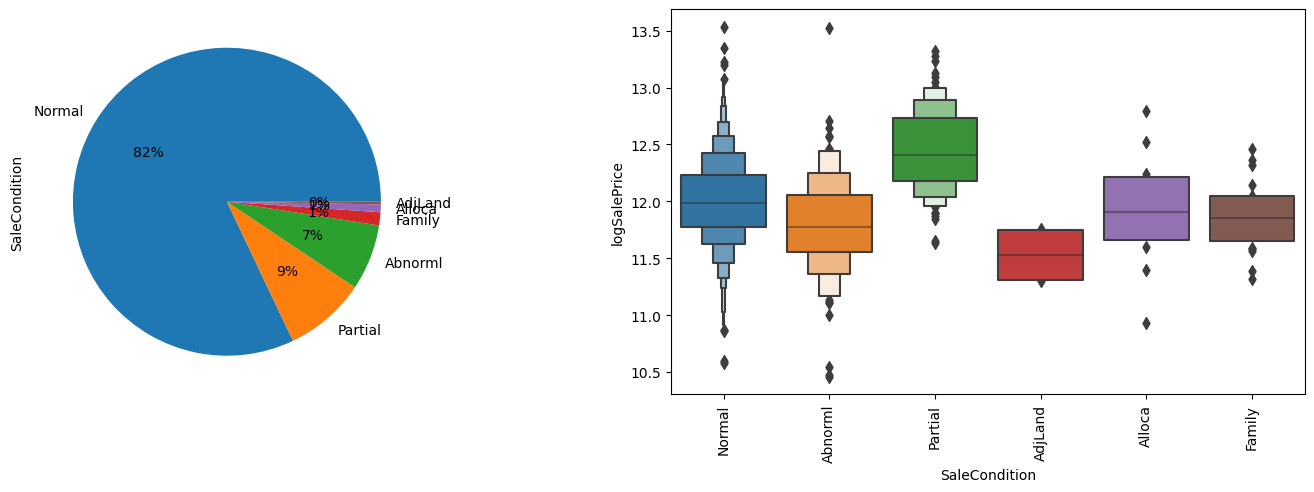

In [331]:
col = 'SaleCondition'
df[col].value_counts()
fig, ax = plt.subplots(ncols=2, figsize=(18,5));
df[col].value_counts(dropna=False).plot.pie(autopct='%.0f%%', ax=ax[0])
sns.boxenplot(data=df, x=col, y='logSalePrice', ax=ax[1])
ax[1].tick_params(axis='x', rotation=90)

In [325]:
df.MasVnrType.isna().sum()


8